In [1]:
from qiskit import *
from qiskit.visualization import *
import scipy
from scipy.optimize import minimize
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA,SLSQP,SPSA, ADAM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings("ignore")

qasmsim = BasicAer.get_backend("qasm_simulator")
statevecsim = BasicAer.get_backend("statevector_simulator")

In [2]:
def d_parity_function(feature_vector, d_params, num_ansatz_reps):

    num_qubits = len(feature_vector)
    qc = QuantumCircuit(num_qubits,1)

    #---------- QUANTUM FEATURE MAP ------------ #
    for qubit, variable in enumerate(feature_vector):
        qc.ry(variable, qubit)
    
    # -------------- ANSATZ --------------- #
    qc.barrier()
    ansatz = RealAmplitudes(num_qubits=num_qubits, 
                            reps=num_ansatz_reps,
                            ).assign_parameters(d_params)

    # --------------- MEASUREMENT ------------------ #
    qc.append(ansatz, list(range(num_qubits)))
    qc.measure(len(feature_vector)-1 , 0)
    counts = execute(qc, backend=qasmsim, counts=TOTAL_COUNTS).result().get_counts(qc)
    P_d = counts
    
    # ------------ FIXING QISKIT BUGS ------------ #
    if '0' not in P_d:
        P_d['0']=0
    if '1' not in P_d:
        P_d['1']=0

    # ----------- PARITY FUNCTION <Z> ------------ #
    exp_value =  (P_d['0'] - P_d['1'])/TOTAL_COUNTS                   
    norm_exp_value = (exp_value + 1)/2

    return norm_exp_value

In [3]:
def g_distribution(latent_vector, g_params, num_ansatz_reps):

    """Generate a fake sample with a quantum circuit."""

    num_qubits = len(latent_vector) - AUX_QUBITS
    total_qubits = len(latent_vector)
    qc = QuantumCircuit(total_qubits, num_qubits)

    # -------------------- QUANTUM FEATURE MAP -------------------- #
    for qubit, variable in enumerate(latent_vector):
        qc.ry(variable, qubit)
    
    # --------------------------- ANSATZ -------------------------- #
    qc.barrier()
    ansatz = RealAmplitudes(num_qubits=total_qubits, 
                            reps=num_ansatz_reps,
                            ).assign_parameters(g_params)

    # ----------------- GENERATOR DISTRIBUTION ------------------- #
    qc.append(ansatz, list(range(total_qubits)))
    qc.measure(range(num_qubits), range(num_qubits))
    counts = execute(qc, backend=qasmsim, shots=TOTAL_COUNTS).result().get_counts(qc)

    # ------------------ SORTED DISTRIBUTION --------------------- #
    strings=['00','01','10','11']

    sorted_counts = {}
    for string in strings:
        if string not in counts:
            counts[string]=0
        sorted_counts[string] = counts[string]

    probs = []
    for key, value in sorted_counts.items():
        probs.append( (2*np.pi* value) / TOTAL_COUNTS)

    return probs

In [4]:
def d_loss(disc_params):
    # -------------------- DISCRIMINATOR CROSS-ENTROPY --------------------- #
    d_loss = 0
    for fake_data, real_data in zip(fake_minibatch, real_minibatch):
        # ---------------- PASS FAKE DATA ON DISCRIMINATOR ----------------- #
        fake_y_estimator = d_parity_function(feature_vector = fake_data, 
                                             d_params = disc_params, 
                                             num_ansatz_reps = d_num_reps)
        # ------------------ DISCRIMINATOR LOSS FOR FAKE ------------------- #            
        #d_loss_fake = -(np.log(1 - fake_y_estimator))
        d_loss_fake = (fake_y_estimator)**2
        # ---------------- PASS REAL DATA ON DISCRIMINATOR ----------------- #
        real_y_estimator = d_parity_function(feature_vector = real_data, 
                                             d_params = disc_params, 
                                             num_ansatz_reps = d_num_reps)
        # ------------------ DISCRIMINATOR LOSS FOR REAL ------------------- #            
        #d_loss_real = -(np.log(real_y_estimator))
        d_loss_real = (1-real_y_estimator)**2
        # -----------------DISCRIMINATOR CROSS ENTROPY --------------------- #
        d_loss += d_loss_fake + d_loss_real
    d_loss = d_loss/NUM_SAMPLES
    return d_loss

In [5]:
def g_loss(gen_params):
    # ------------------------- FAKE MINIBATCH ------------------------- #
    fake_minibatch = []
    for z in latent_minibatch:
        fake_sample = g_distribution(latent_vector = z, 
                                     g_params = gen_params, 
                                     num_ansatz_reps = g_num_reps)
        fake_minibatch.append(fake_sample)
    # -------------------- GENERATOR CROSS-ENTROPY --------------------- #
    g_loss = 0    
    for fake_data in fake_minibatch:
        # ---------------- PASS FAKE DATA ON DISCRIMINATOR ----------------- #
        fake_y_estimator = d_parity_function(feature_vector = fake_data, 
                                             d_params = optimal_params_discriminator, 
                                             num_ansatz_reps = d_num_reps)
        # ------------------------ GENERATOR LOSS -------------------------- #
        #g_loss = -np.log(fake_y_estimator)
        g_loss = (1-fake_y_estimator)**2
    g_loss = g_loss/NUM_SAMPLES
    return g_loss

In [6]:
def relative_entropy(G, X):

    d_kl = 0
    for x in X:
        for g in G:
            #d_kl += sum([(g[i]*np.log(g[i]/x[i]))
            d_kl += sum([(g[i]-x[i])**2
                            for i in range(len(g))])

    return d_kl

In [16]:
# ------------------- DATA PREPROCESSING ------------------ #
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data'))
filename = "irissetosa.data"
data = pd.read_csv(os.path.join(path,filename))
label = data.iloc[:, -1]
features = data.iloc[:, :-1]
x = features.values
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 2*np.pi))
x_scaled = min_max_scaler.fit_transform(x)
features = pd.DataFrame(x_scaled)
data = features.assign(labels = label)

# --------------- PARAMETERS OF THE PROBLEMS -------------- #
TOTAL_COUNTS= 1024; AUX_QUBITS = 1
GEN_IT = 3; EPOCHS=40; DISC_IT = 6; NUM_SAMPLES = data.shape[0]
g_num_qubits = 2; d_num_qubits = 4; g_num_reps = 4; d_num_reps = 3
total_g_qubits = g_num_qubits + AUX_QUBITS
g_initial_guess = np.random.uniform(0, np.pi, total_g_qubits + total_g_qubits*g_num_reps)
d_initial_guess = np.random.uniform(0, np.pi, d_num_qubits + d_num_qubits*d_num_reps)
loss_values_discriminator, loss_values_generator, KL_divergence = [], [], []

In [17]:
# ---------------- PREPARE REAL MINIBATCH  --------------- #    
real_minibatch = []

for m in range(NUM_SAMPLES):        
    # --------------------- SAMPLE FROM REAL DATA ---------------------- #
    real_vector = data.iloc[m, :-1] 
    real_minibatch.append(real_vector)

# ---------------- SETTING THE OPTIMIZERS  --------------- #
disc_optimizer = ADAM(maxiter=2, tol=1e-06, lr=0.05, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10)
gen_optimizer = ADAM(maxiter=2, tol=1e-06, lr=0.05, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10)

disc_optimizer = SLSQP(maxiter=2)
gen_optimizer = SLSQP(maxiter=2)

In [18]:
for epoch in range(EPOCHS):

    print(f"--------------------------------------------------- epoch = {epoch} ---------------------------------------------------")
    # --------------- PREPARE LATENT MINIBATCH  -----------------#
    latent_minibatch = []
    for m in range(NUM_SAMPLES):        
        # -------------------- GENERATE LATENT VECTOR ---------------------- #
        latent_vec = np.random.uniform(0, 2*np.pi, total_g_qubits)
        #latent_vec = [np.pi*np.random.random(), 2*np.pi*np.random.random()]
        latent_minibatch.append(latent_vec)
    # ------------------------- FAKE MINIBATCH ------------------------- #
    fake_minibatch = []
    for z in latent_minibatch:
        fake_sample = g_distribution(latent_vector = z, 
                                     g_params = g_initial_guess, 
                                     num_ansatz_reps = g_num_reps)
        fake_minibatch.append(fake_sample)    
    # ------------------ TRAIN DISCRIMINATOR --------------------#
    #for _ in range(DISC_IT):
    result_d = disc_optimizer.minimize(fun = d_loss, x0 = np.zeros(len(d_initial_guess)))                                      
    optimal_params_discriminator = result_d.x
    d_initial_guess = optimal_params_discriminator
    loss_values_discriminator.append(result_d.fun)
    loss_values_generator.append(g_loss(g_initial_guess))
    print(f"Discriminator Loss: {result_d.fun} \t Generator Loss: {g_loss(g_initial_guess)}")
    # ------------------ TRAIN GENERATOR --------------------#
    #for _ in range(GEN_IT):
    result_g = gen_optimizer.minimize(fun = g_loss, x0 = np.zeros(len(g_initial_guess)))
    optimal_params_generator = result_g.x
    g_initial_guess = optimal_params_generator
    loss_values_generator.append(result_g.fun)
    loss_values_discriminator.append(d_loss(d_initial_guess))
    print(f"Discriminator Loss: {d_loss(d_initial_guess)} \t Generator Loss: {result_g.fun}")
    # ------------------ RELATIVE ENTROPY -------------------#
    kl_divergence = relative_entropy(fake_minibatch, real_minibatch)
    KL_divergence.append(kl_divergence)

    print(f"Discriminator Loss: {result_d.fun} \t Generator Loss: {result_g.fun} \t KL Divergence: {kl_divergence}")

--------------------------------------------------- epoch = 0 ---------------------------------------------------
Discriminator Loss: 0.5106154266668825 	 Generator Loss: 0.0033843565960319675
Discriminator Loss: 0.5190114585720763 	 Generator Loss: 0.0074332879514110335
Discriminator Loss: 0.5106154266668825 	 Generator Loss: 0.0074332879514110335 	 KL Divergence: 48792.13972480891
--------------------------------------------------- epoch = 1 ---------------------------------------------------
Discriminator Loss: 0.48781511734943 	 Generator Loss: 0.00563337364975287
Discriminator Loss: 0.4827480121534698 	 Generator Loss: 0.0033843565960319675
Discriminator Loss: 0.48781511734943 	 Generator Loss: 0.0033843565960319675 	 KL Divergence: 53951.793115991546
--------------------------------------------------- epoch = 2 ---------------------------------------------------
Discriminator Loss: 0.5093194611218511 	 Generator Loss: 0.005802154541015625
Discriminator Loss: 0.5195483966749541 	 

KeyboardInterrupt: 

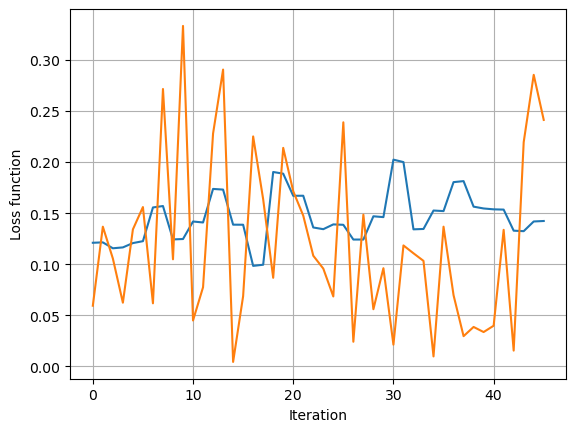

In [19]:
loss_values_discriminator = loss_values_discriminator/np.linalg.norm(loss_values_discriminator)
loss_values_generator = loss_values_generator/np.linalg.norm(loss_values_generator)

plt.plot(loss_values_discriminator)
plt.plot(loss_values_generator)
plt.ylabel('Loss function')
plt.xlabel("Iteration")
plt.grid()


In [ ]:
NUM_NEW_SAMPLES = 50; new_samples = []
for sample in range(NUM_NEW_SAMPLES):
    # ----------------------- NEW LATENT VECTOR ------------------------ #
    latent_vec = np.random.uniform(0, 2*np.pi, g_num_qubits)
    # ---------------- PASS LATENT VECTOR ON GENERATOR ----------------- #
    fake_distr = g_distribution(latent_vector=latent_vec, 
                                g_params=optimal_params_generator, 
                                num_ansatz_reps=g_num_reps)
    # -------------------- GENERATE FAKE DISTRIBUTION ------------------ #          
    new_samples.append(fake_distr)

print("NEW SAMPLES DERIVED FROM QUANTUM GENERATOR: \n ", np.matrix(new_samples)[:5])